# Bachelors Thesis: News Sentiment and Inflation Expectation
Luis Nägelin

19-613-926

Gallusstrasse 41, 9000 St.Gallen

luis.naegelin@student.unisg.ch

Disclaimer and declaration of autorship:

The following code has been written by me (Luis Nägelin) without the direct help of any other person.

I have used tools like Stack-overflow and ChatGPT to write the code.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize as NLTKWordTokenizer
from IPython.display import clear_output

import pysentiment2 as ps
lm = ps.LM() # import the Loughran McDonald dictionary

In [8]:
# important global Parameters
# path to the data
path_to_data = '###########' # path to the data -> folder: NYT_metadata_text
path_out = '########'  # path to save the outputs.

name_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

### Functions:

In [2]:
# Load Data Function
def load_data(path, file_name):
    # Concatenate the file name and the '.csv' extension
    filename = file_name + '.csv'
    # Read the CSV file located at the specified path, using the concatenated filename as the file to be loaded
    # The index_col=0 argument sets the first column of the CSV file as the index column
    # Uncomment the following line and use it if you want to load the 'keywords' column as lists
    # converters={'keywords': lambda x: x.strip("[]").replace('"', "'").replace("'","").split(', ')}
    data = pd.read_csv(path + filename, index_col=0)
    
    # Clear the output to provide a cleaner display
    clear_output(wait=True)
    
    # Print the name of the loaded file
    print('loaded:', filename)
    
    # Return the loaded data
    return data


In [3]:
def filter_relevant_articles(data):
    # Filter the 'data' DataFrame to include only rows where the 'keywords' column contains the strings 'United States' or 'UNITED STATES'
    data = data[data['keywords'].str.contains('United States|UNITED STATES', na=False)]

    # Define a list of relevant article types
    relevant_type_material = ['News', 'Letter', 'Op-Ed', 'Editorial', 'Brief']

    # Filter the 'data' DataFrame to include only rows where the 'type_material' column contains any of the relevant article types
    data = data[data['type_material'].str.contains('|'.join(relevant_type_material), na=False)]

    # Return the filtered 'data' DataFrame
    return data


In [6]:
def filter_for_inflation(data):
    # Define a list of keywords related to inflation
    keywords = ['price index', 'price-index', 'price level', 'inflation', 'deflation', 'rising cost', 'rising costs',
                'falling cost', 'falling costs', 'rising prices', 'price surge', 'falling prices', 'price-hike',
                'price hike']

    # Filter the 'data' DataFrame to include only rows where the 'text' column contains any of the keywords
    data = data[data['text'].str.contains('|'.join(keywords), na=False)]

    # Return the filtered 'data' DataFrame
    return data


### Test and improve the filters

In [11]:
# Specify the year and month for filtering
year = '2021'
month = name_months[5]  # 'name_months' contains the names of the months

# Generate the filename based on the year and month
my_filename = year + '/NYT_metadata' + year + '_' + month

# Load the data from the specified file
loaded_data = load_data(path_to_data, my_filename)

# Filter the loaded data for relevant articles
filtered_articles = filter_relevant_articles(loaded_data)

# Further filter the relevant articles for inflation-related content
filtered_inflation_articles = filter_for_inflation(filtered_articles)

# Print the number of paragraphs (length) in the filtered data
print(len(filtered_inflation_articles['text']))

# Write the filtered paragraphs to a text file
with open(path_out + '/filtered_paragraphes.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(filtered_inflation_articles['text']))


loaded: 2021/NYT_metadata2021_June.csv
17


In [ ]:
# show some data:
filtered_inflation_articles.head()

### Sentiment Analysis
The following block loads the monthly data and preforems the sentiment analysis on the test data. Then the results are stored in np.arrays. It loops over the specivied range of data.

In [16]:
# Specify the text source (collum of text to preform the sentiment analysis on)
text_source = 'text'

# Specify the start and end years for data processing
y_start = 2020
y_end = 2023

# Initialize variables for storing results and counts
total_number_of_articles = np.array([])  # Total number of articles
sentiment_of_articles = []  # Results of sentiment analysis per month
positive_articles_per_month = np.array([])  # Number of positive articles per month
negative_articles_per_month = np.array([])  # Number of negative articles per month
neutral_articles_per_month = np.array([])  # Number of neutral articles per month
mean_sentiment_per_month = np.array([])  # Mean sentiment per month
relevant_articles_per_month = np.array([])  # Number of relevant articles per month
inflation_articles_per_month = np.array([])  # Number of inflation-related articles per month
empty_counter = 0  # Counter for empty articles

# Iterate over years and months
for y in range(y_start, y_end):
    year = str(y)

    for i in range(0, 12):
        month = name_months[i]  # Assuming the 'name_months' variable is defined and contains the names of the months

        # Generate the filename based on the year and month
        my_filename = year + '/NYT_metadata' + year + '_' + month

        # Load the data from the specified file
        data = load_data(path_to_data, my_filename)

        # Append the total number of articles to the array
        total_number_of_articles = np.append(total_number_of_articles, len(data))

        # Filter the data for relevant articles
        data = filter_relevant_articles(data)

        # Append the number of relevant articles to the array
        relevant_articles_per_month = np.append(relevant_articles_per_month, len(data))

        # Filter the relevant articles for inflation-related content
        data = filter_for_inflation(data)

        # Initialize counters for positive, negative, and neutral articles
        articles_counter = 0
        positive_articles = 0
        neutral_articles = 0
        negative_articles = 0

        # Iterate over the data to perform sentiment analysis
        for index in data.index:
            text = data.loc[index, text_source]

            if isinstance(text, str):
                articles_counter += 1

                # Perform sentiment analysis on the text
                tokenized_text = lm.tokenize(text)
                score = lm.get_score(tokenized_text)['Polarity']

                # Increase the respective counter based on the sentiment score
                if score > 0:
                    positive_articles += 1
                elif score < 0:
                    negative_articles += 1
                else:
                    neutral_articles += 1

        # Store the sentiment analysis results for the month
        sentiment_of_articles.append(np.array([positive_articles, neutral_articles, negative_articles]))

        # Store the number of relevant articles for inflation analysis in this month
        inflation_articles_per_month = np.append(inflation_articles_per_month, articles_counter)

# Store the Results in the global nt.arrays
for results_per_month in sentiment_of_articles:
    if results_per_month.sum() == 0:
        # There were no relevant articles in this month, so all values are set to 0
        mean_sentiment_per_month = np.append(mean_sentiment_per_month, 0)
        positive_articles_per_month = np.append(positive_articles_per_month, 0)
        neutral_articles_per_month = np.append(neutral_articles_per_month, 0)
        negative_articles_per_month = np.append(negative_articles_per_month, 0)
    else:
        # Calculate the mean sentiment score per month
        mean = (results_per_month[0] - results_per_month[2]) / results_per_month.sum()
        mean_sentiment_per_month = np.append(mean_sentiment_per_month, mean)

        # Store the number of positive, neutral, and negative articles per month
        positive_articles_per_month = np.append(positive_articles_per_month, results_per_month[0])
        neutral_articles_per_month = np.append(neutral_articles_per_month, results_per_month[1])
        negative_articles_per_month = np.append(negative_articles_per_month, results_per_month[2])


loaded: 2022/NYT_metadata2022_December.csv


### Plot Results for first Analysis

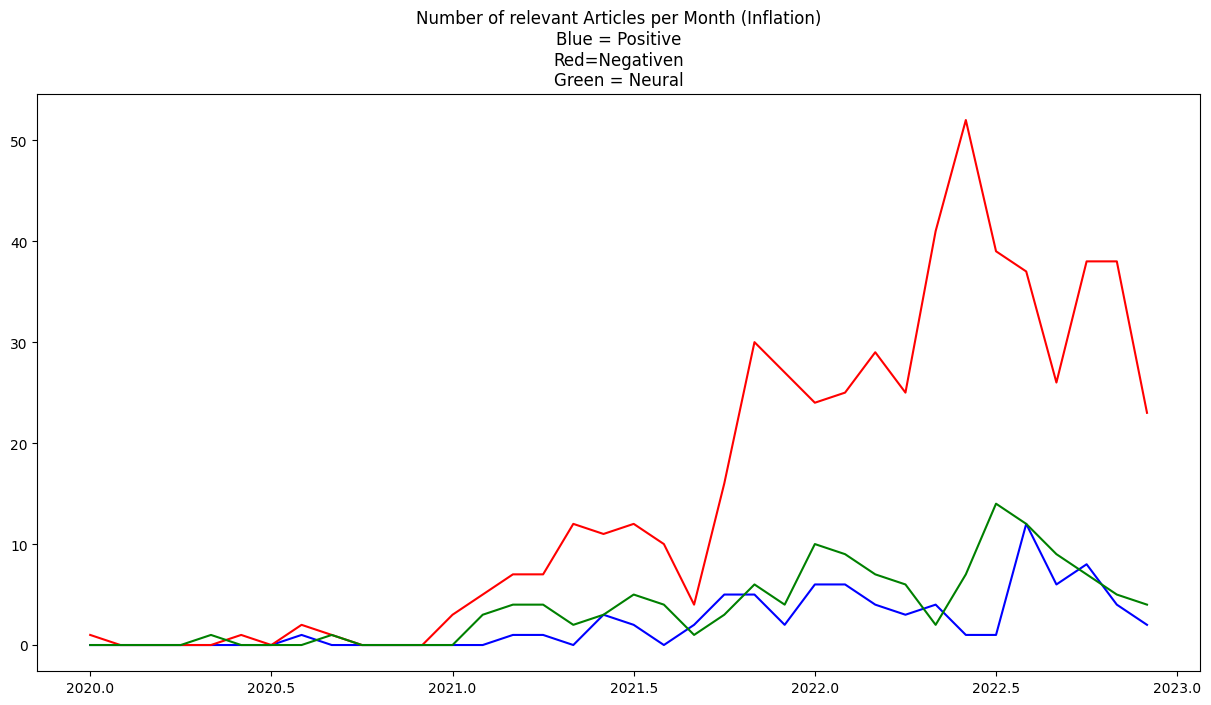

In [17]:
plt.figure(figsize=(15,7.5))

plt.plot(np.asanyarray(np.arange(y_start,y_end,1/12)),positive_articles_per_month, 'b')
plt.plot(np.asanyarray(np.arange(y_start,y_end,1/12)),negative_articles_per_month, 'r')
plt.plot(np.asanyarray(np.arange(y_start,y_end,1/12)),neutral_articles_per_month, 'g')
plt.title('Number of relevant Articles per Month (Inflation)\nBlue = Positive\nRed=Negativen\nGreen = Neural')
plt.show()

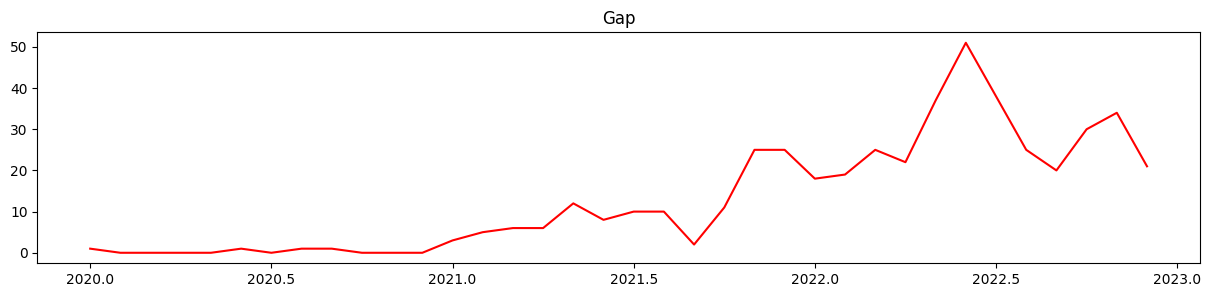

In [18]:
gap = negative_articles_per_month - positive_articles_per_month 

plt.figure(figsize=(15,3))
plt.plot(np.asanyarray(np.arange(y_start,y_end,1/12)),gap , 'red')
plt.title('Gap')
plt.show()

### Save Results
Store the results as csv file.

In [19]:
# Create a DataFrame to consolidate the results
results = pd.DataFrame({
    'Date': np.arange(y_start, y_end, 1/12),  # Create a date range from the start year to the end year with monthly intervals
    'total_num_articles': total_number_of_articles,  # Total number of articles per month
    'num_of_relevant_articles': relevant_articles_per_month,  # Number of relevant articles per month
    'inflation_articles_per_month': inflation_articles_per_month,  # Number of inflation-related articles per month
    'positive_articles': positive_articles_per_month,  # Number of positive articles per month
    'neutral_articles': neutral_articles_per_month,  # Number of neutral articles per month
    'negative_articles': negative_articles_per_month,  # Number of negative articles per month
    'sentiment_gap': negative_articles_per_month - positive_articles_per_month  # Difference between negative and positive articles per month
})

# Save the results to a CSV file
results.to_csv(path_out + '/sentiment_results.csv', index=False)